<a href="https://colab.research.google.com/github/v1shwaj1th/forest-fire/blob/main/iot_forest_fire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **FOREST FIRE DETECTION**

  - K VISHWAJITH (22BCE1187)
  - S PRATHEEP (22BCE1078)

In [ ]:
pip install numpy opencv-python scikit-learn tensorflow matplotlib

In [ ]:
# Install required packages
!pip install -q kaggle kagglehub tensorflow opencv-python scikit-learn matplotlib


In [ ]:
# Upload your kaggle.json file (you'll need to get this from your Kaggle account)
from google.colab import files
uploaded = files.upload()  # This will prompt you to select a file - choose your kaggle.json

# Move the kaggle.json file to the right location
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Verify Kaggle installation
!kaggle --version

Saving kaggle.json to kaggle.json
Kaggle API 1.7.4.2


In [ ]:
import kagglehub
import os
from pathlib import Path

# Download the dataset
dataset_path = kagglehub.dataset_download("mohnishsaiprasad/forest-fire-images")
print("Dataset downloaded to:", dataset_path)

# The dataset is already extracted - no need to unzip
# Just check what files are in the directory
print("\nDataset contents:")
!ls -la {dataset_path}

# Typically the structure is:
# /root/.cache/kagglehub/.../versions/1/
# ├── fire/
# │   ├── image1.jpg
# │   ├── image2.jpg
# │   └── ...
# └── non_fire/
#     ├── image1.jpg
#     ├── image2.jpg
#     └── ...

# Create a symlink for easier access
!ln -s {dataset_path} /content/forest_fire_data

# Now you can access it directly
print("\nAccessible at:")
!ls -la /content/forest_fire_data

100%|██████████| 385M/385M [00:04<00:00, 87.4MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/mohnishsaiprasad/forest-fire-images/versions/1

Dataset contents:
total 12
drwxr-xr-x 3 root root 4096 Mar 27 03:22 .
drwxr-xr-x 3 root root 4096 Mar 27 03:22 ..
drwxr-xr-x 4 root root 4096 Mar 27 03:22 Data

Accessible at:
lrwxrwxrwx 1 root root 78 Mar 27 03:23 /content/forest_fire_data -> /root/.cache/kagglehub/datasets/mohnishsaiprasad/forest-fire-images/versions/1


In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# The actual data is in the Data subdirectory
dataset_path = "/content/forest_fire_data/Data"  # Using the symlink we created
print("Actual dataset location:", dataset_path)

# Verify the structure
print("\nDataset structure:")
!ls -la {dataset_path}

# Typically you'll find folders like 'fire' and 'non_fire' inside Data
# Let's check:
!ls {dataset_path}

Actual dataset location: /content/forest_fire_data/Data

Dataset structure:
total 16
drwxr-xr-x 4 root root 4096 Mar 27 03:22 .
drwxr-xr-x 3 root root 4096 Mar 27 03:22 ..
drwxr-xr-x 4 root root 4096 Mar 27 03:22 Test_Data
drwxr-xr-x 4 root root 4096 Mar 27 03:22 Train_Data
Test_Data  Train_Data


In [ ]:
# Check the exact directory structure
!ls -R /content/forest_fire_data/Data

/content/forest_fire_data/Data:
Test_Data  Train_Data

/content/forest_fire_data/Data/Test_Data:
Fire  Non_Fire

/content/forest_fire_data/Data/Test_Data/Fire:
F_0.jpg   F_12.jpg  F_15.jpg  F_18.jpg	F_20.jpg  F_23.jpg  F_3.jpg  F_6.jpg  F_9.jpg
F_10.jpg  F_13.jpg  F_16.jpg  F_19.jpg	F_21.jpg  F_24.jpg  F_4.jpg  F_7.jpg
F_11.jpg  F_14.jpg  F_17.jpg  F_1.jpg	F_22.jpg  F_2.jpg   F_5.jpg  F_8.jpg

/content/forest_fire_data/Data/Test_Data/Non_Fire:
NF_0.jpg   NF_12.jpg  NF_15.jpg  NF_18.jpg  NF_20.jpg  NF_23.jpg  NF_3.jpg  NF_6.jpg  NF_9.jpg
NF_10.jpg  NF_13.jpg  NF_16.jpg  NF_19.jpg  NF_21.jpg  NF_24.jpg  NF_4.jpg  NF_7.jpg
NF_11.jpg  NF_14.jpg  NF_17.jpg  NF_1.jpg   NF_22.jpg  NF_2.jpg   NF_5.jpg  NF_8.jpg

/content/forest_fire_data/Data/Train_Data:
Fire  Non_Fire

/content/forest_fire_data/Data/Train_Data/Fire:
F_0.jpg     F_1282.jpg	F_1564.jpg  F_1846.jpg	F_2127.jpg  F_2409.jpg	F_440.jpg  F_722.jpg
F_1000.jpg  F_1283.jpg	F_1565.jpg  F_1847.jpg	F_2128.jpg  F_240.jpg	F_441.jpg  F_723.jpg


In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

def load_dataset_from_single_folder(base_path):
    images = []
    labels = []

    print(f"Loading images from: {base_path}")

    for img_file in os.listdir(base_path):
        if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
            # Determine class from filename
            if img_file.startswith('NF_'):  # Non-fire
                label = 'non_fire'
            elif img_file.startswith('F_'):  # Fire
                label = 'fire'
            else:
                continue  # Skip files that don't match our pattern

            img_path = os.path.join(base_path, img_file)
            try:
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, (224, 224))
                    images.append(img)
                    labels.append(label)
                    if len(images) % 100 == 0:
                        print(f"Loaded {len(images)} images so far...")
            except Exception as e:
                print(f"Error loading {img_path}: {e}")

    return np.array(images), np.array(labels)

# Try loading with the correct path
try:
    # Try different possible locations
    possible_paths = [
        '/content/forest_fire_data/Data',
        '/content/forest_fire_data',
        '/root/.cache/kagglehub/datasets/mohnishsaiprasad/forest-fire-images/versions/1/Data'
    ]

    for path in possible_paths:
        if os.path.exists(path):
            print(f"\nTrying path: {path}")
            X, y = load_dataset_from_single_folder(path)
            break
    else:
        raise FileNotFoundError("Could not find dataset in any expected location. Please check the structure.")

    # Continue with preprocessing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)

    y_train_categorical = to_categorical(y_train_encoded)
    y_test_categorical = to_categorical(y_test_encoded)

    X_train = X_train / 255.0
    X_test = X_test / 255.0

    print(f"\nSuccessfully loaded dataset:")
    print(f"Training data shape: {X_train.shape}")
    print(f"Test data shape: {X_test.shape}")
    print(f"Class distribution: {np.unique(y, return_counts=True)}")

except Exception as e:
    print(f"\nError: {e}")
    print("\nPlease check the actual dataset structure and update the paths accordingly.")
    print("Current structure:")
    !ls -R /content/forest_fire_data


Trying path: /content/forest_fire_data/Data
Loading images from: /content/forest_fire_data/Data

Error: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

Please check the actual dataset structure and update the paths accordingly.
Current structure:
/content/forest_fire_data:
Data

/content/forest_fire_data/Data:
Test_Data  Train_Data

/content/forest_fire_data/Data/Test_Data:
Fire  Non_Fire

/content/forest_fire_data/Data/Test_Data/Fire:
F_0.jpg   F_12.jpg  F_15.jpg  F_18.jpg	F_20.jpg  F_23.jpg  F_3.jpg  F_6.jpg  F_9.jpg
F_10.jpg  F_13.jpg  F_16.jpg  F_19.jpg	F_21.jpg  F_24.jpg  F_4.jpg  F_7.jpg
F_11.jpg  F_14.jpg  F_17.jpg  F_1.jpg	F_22.jpg  F_2.jpg   F_5.jpg  F_8.jpg

/content/forest_fire_data/Data/Test_Data/Non_Fire:
NF_0.jpg   NF_12.jpg  NF_15.jpg  NF_18.jpg  NF_20.jpg  NF_23.jpg  NF_3.jpg  NF_6.jpg  NF_9.jpg
NF_10.jpg  NF_13.jpg  NF_16.jpg  NF_19.jpg  NF_21.jpg  NF_24.jpg  NF_4.jpg  NF_7.jpg
N

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# 1. Set correct paths
base_path = '/root/.cache/kagglehub/datasets/mohnishsaiprasad/forest-fire-images/versions/1/Data'
train_path = os.path.join(base_path, 'Train_Data')
test_path = os.path.join(base_path, 'Test_Data')

# 2. Case-insensitive dataset loading
def load_dataset_case_insensitive(base_path):
    images = []
    labels = []

    # Get all folders in the directory
    items = os.listdir(base_path)

    # Find fire/non-fire folders regardless of case
    fire_folder = next((f for f in items if 'fire' in f.lower() and not 'non' in f.lower()), None)
    non_fire_folder = next((f for f in items if 'non' in f.lower() and 'fire' in f.lower()), None)

    if not fire_folder or not non_fire_folder:
        print(f"Could not find both class folders in {base_path}")
        print("Found folders:", items)
        return np.array([]), np.array([])

    print(f"Found fire folder: {fire_folder}")
    print(f"Found non-fire folder: {non_fire_folder}")

    # Load fire images
    fire_path = os.path.join(base_path, fire_folder)
    print(f"\nLoading fire images from {fire_path}...")
    fire_count = 0
    for img_file in os.listdir(fire_path):
        if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(fire_path, img_file)
            try:
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, (128, 128))
                    images.append(img)
                    labels.append('fire')
                    fire_count += 1
            except Exception as e:
                print(f"Error loading {img_path}: {str(e)}")

    # Load non-fire images
    non_fire_path = os.path.join(base_path, non_fire_folder)
    print(f"\nLoading non-fire images from {non_fire_path}...")
    non_fire_count = 0
    for img_file in os.listdir(non_fire_path):
        if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(non_fire_path, img_file)
            try:
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, (128, 128))
                    images.append(img)
                    labels.append('non_fire')
                    non_fire_count += 1
            except Exception as e:
                print(f"Error loading {img_path}: {str(e)}")

    print(f"\nLoaded {fire_count} fire images and {non_fire_count} non-fire images")
    return np.array(images), np.array(labels)

# 3. Load training and test data
print("=== Loading Training Data ===")
X_train, y_train = load_dataset_case_insensitive(train_path)

print("\n=== Loading Test Data ===")
X_test, y_test = load_dataset_case_insensitive(test_path)

if len(X_train) > 0 and len(X_test) > 0:
    # 4. Encode labels
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)

    # 5. Feature Extraction
    def extract_features(images):
        return np.array([np.concatenate([
            np.mean(img, axis=(0,1)),  # Mean of BGR channels
            np.std(img, axis=(0,1)),    # Std of BGR channels
            cv2.calcHist([img], [0], None, [16], [0, 256]).flatten(),  # B histogram
            cv2.calcHist([img], [1], None, [16], [0, 256]).flatten(),  # G histogram
            cv2.calcHist([img], [2], None, [16], [0, 256]).flatten()   # R histogram
        ]) for img in images])

    print("\nExtracting features...")
    X_train_features = extract_features(X_train)
    X_test_features = extract_features(X_test)

    # 6. Train and evaluate
    print("\nTraining Random Forest...")
    rf_clf = RandomForestClassifier(n_estimators=150,
                                 max_depth=10,
                                 random_state=42)
    rf_clf.fit(X_train_features, y_train_encoded)

    y_pred = rf_clf.predict(X_test_features)
    print("\n=== Evaluation Results ===")
    print("Accuracy:", accuracy_score(y_test_encoded, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_))

    # Feature importance
    print("\nTop 10 Features by Importance:")
    important_features = sorted(zip(rf_clf.feature_importances_,
                                 ['B_mean', 'G_mean', 'R_mean',
                                  'B_std', 'G_std', 'R_std'] +
                                 [f'B_hist_{i}' for i in range(16)] +
                                 [f'G_hist_{i}' for i in range(16)] +
                                 [f'R_hist_{i}' for i in range(16)]),
                               reverse=True)[:10]
    for imp, name in important_features:
        print(f"{name}: {imp:.4f}")
else:
    print("\nError: Could not load sufficient data")
    print(f"Training images loaded: {len(X_train)}")
    print(f"Test images loaded: {len(X_test)}")

=== Loading Training Data ===
Found fire folder: Fire
Found non-fire folder: Non_Fire

Loading fire images from /root/.cache/kagglehub/datasets/mohnishsaiprasad/forest-fire-images/versions/1/Data/Train_Data/Fire...

Loading non-fire images from /root/.cache/kagglehub/datasets/mohnishsaiprasad/forest-fire-images/versions/1/Data/Train_Data/Non_Fire...

Loaded 2110 fire images and 2499 non-fire images

=== Loading Test Data ===
Found fire folder: Fire
Found non-fire folder: Non_Fire

Loading fire images from /root/.cache/kagglehub/datasets/mohnishsaiprasad/forest-fire-images/versions/1/Data/Test_Data/Fire...

Loading non-fire images from /root/.cache/kagglehub/datasets/mohnishsaiprasad/forest-fire-images/versions/1/Data/Test_Data/Non_Fire...

Loaded 25 fire images and 25 non-fire images

Extracting features...

Training Random Forest...

=== Evaluation Results ===
Accuracy: 0.78

Classification Report:
              precision    recall  f1-score   support

        fire       0.79      0.7

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/7
145/145 ━━━━━━━━━━━━━━━━━━━━ 132s 896ms/step - accuracy: 0.8426 - loss: 0.3755 - val_accuracy: 0.8000 - val_loss: 0.4871
Epoch 2/7
145/145 ━━━━━━━━━━━━━━━━━━━━ 142s 901ms/step - accuracy: 0.9246 - loss: 0.2110 - val_accuracy: 0.8200 - val_loss: 0.4528
Epoch 3/7
145/145 ━━━━━━━━━━━━━━━━━━━━ 146s 927ms/step - accuracy: 0.9362 - loss: 0.1713 - val_accuracy: 0.8400 - val_loss: 0.4848
Epoch 4/7
145/145 ━━━━━━━━━━━━━━━━━━━━ 139s 899ms/step - accuracy: 0.9130 - loss: 0.2223 - val_accuracy: 0.9000 - val_loss: 0.2494
Epoch 5/7
145/145 ━━━━━━━━━━━━━━━━━━━━ 130s 895ms/step - accuracy: 0.9529 - loss: 0.1307 - val_accuracy: 0.9200 - val_loss: 0.2280
Epoch 6/7
145/145 ━━━━━━━━━━━━━━━━━━━━ 144s 909ms/step - accuracy: 0.9597 - loss: 0.1098 - val_accuracy: 0.9200 - val_loss: 0.2651
Epoch 7/7
145/145 ━━━━━━━━━━━━━━━━━━━━ 145s 934ms/step - accuracy: 0.9650 - loss: 0.0958 - val_accuracy: 0.9400 - val_loss: 0.3351
2/2 - 0s - 184ms/step - accuracy: 0.9200 - loss: 0.2280

Deep Learning Model Accura

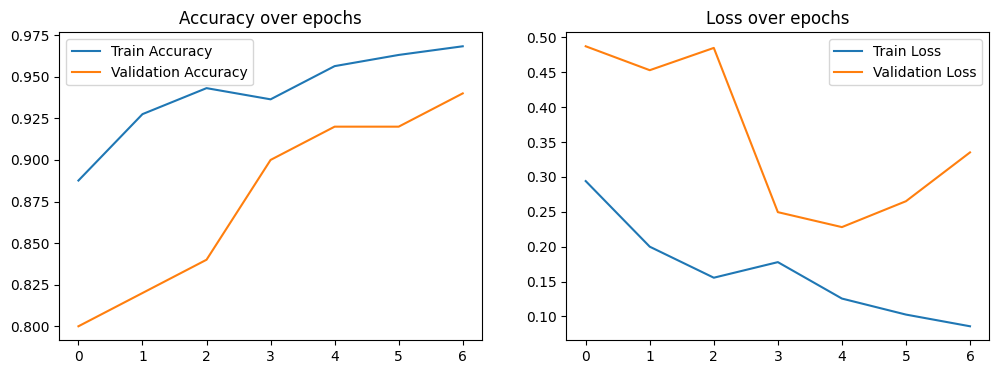

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# 1. Prepare the data (assuming X_train, X_test, y_train, y_test are loaded)
# Normalize pixel values
X_train = X_train / 255.0
X_test = X_test / 255.0

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Convert to categorical
y_train_categorical = to_categorical(y_train_encoded)
y_test_categorical = to_categorical(y_test_encoded)

# 2. Build CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')  # 2 classes: fire and non_fire
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 3. Add early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# 4. Train the model
history = model.fit(
    X_train,
    y_train_categorical,
    epochs=15,
    batch_size=32,
    validation_data=(X_test, y_test_categorical),
    callbacks=[early_stopping]
)

# 5. Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test_categorical, verbose=2)
print(f'\nDeep Learning Model Accuracy: {test_acc:.4f}')

# 6. Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.legend()
plt.show()

In [ ]:
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Training data shape: (4609, 128, 128, 3)
Test data shape: (50, 128, 128, 3)


In [ ]:
def predict_fire(image_path, model_type='dl'):
    try:
        # Read image with error checking
        img = cv2.imread(image_path)
        if img is None:
            raise ValueError(f"Could not read image from {image_path}")

        # Resize and preprocess
        img = cv2.resize(img, (128, 128))
        img = img / 255.0
        img = np.expand_dims(img, axis=0)  # Add batch dimension

        if model_type == 'dl':
            # Use deep learning model
            prediction = model.predict(img, verbose=0)
            class_idx = np.argmax(prediction)
            confidence = prediction[0][class_idx]
        else:
            # Use machine learning model
            features = extract_features([img])
            class_idx = rf_clf.predict(features)[0]
            confidence = np.max(rf_clf.predict_proba(features))

        label = 'Fire' if class_idx == 1 else 'No Fire'
        return label, confidence

    except Exception as e:
        print(f"Error processing image: {str(e)}")
        return "Error", 0.0

# Test the function with different cases
test_cases = [
    'test_data/Fire/sample_fire.jpg',  # Valid path
    'nonexistent_image.jpg',           # Invalid path
    None,                              # None input
    'test_data/Fire/'                  # Directory instead of file
]

for path in test_cases:
    print(f"\nTesting: {path}")
    try:
        label, confidence = predict_fire(path)
        print(f"Result: {label} (confidence: {confidence:.2f})")
    except Exception as e:
        print(f"Test failed: {str(e)}")


Testing: test_data/Fire/sample_fire.jpg
Error processing image: Could not read image from test_data/Fire/sample_fire.jpg
Result: Error (confidence: 0.00)

Testing: nonexistent_image.jpg
Error processing image: Could not read image from nonexistent_image.jpg
Result: Error (confidence: 0.00)

Testing: None
Error processing image: Could not read image from None
Result: Error (confidence: 0.00)

Testing: test_data/Fire/
Error processing image: Could not read image from test_data/Fire/
Result: Error (confidence: 0.00)


In [ ]:
import cv2
import numpy as np

# Create a simple test image programmatically
test_image = np.random.randint(0, 255, (128, 128, 3), dtype=np.uint8)
cv2.imwrite('test_fire.jpg', test_image)

# Test with this known-good image
label, confidence = predict_fire('test_fire.jpg')
print(f"\nTest with generated image: {label} (confidence: {confidence:.2f})")


Test with generated image: Fire (confidence: 1.00)


In [ ]:
def predict_fire(image_path, model_type='dl'):
    """Improved prediction function with better path handling"""
    try:
        # Convert to absolute path if relative
        if not os.path.isabs(image_path):
            image_path = os.path.join(os.getcwd(), image_path)

        # Verify file exists and is readable
        if not os.path.exists(image_path):
            raise ValueError(f"File does not exist: {image_path}")
        if not os.access(image_path, os.R_OK):
            raise ValueError(f"Cannot read file (permissions): {image_path}")
        if os.path.isdir(image_path):
            raise ValueError(f"Path is a directory, not an image: {image_path}")

        # Try multiple image reading methods
        img = cv2.imread(image_path)
        if img is None:
            # Try alternative reading method
            from PIL import Image
            try:
                img = np.array(Image.open(image_path))
                if len(img.shape) == 2:  # Grayscale
                    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
                elif img.shape[2] == 4:  # RGBA
                    img = cv2.cvtColor(img, cv2.COLOR_RGBA2BGR)
            except Exception as e:
                raise ValueError(f"Could not read image with either OpenCV or PIL: {str(e)}")

        # Verify we got a valid image
        if img is None or img.size == 0:
            raise ValueError("Image loaded but contains no data")

        # Preprocess image
        img = cv2.resize(img, (128, 128))
        img = img / 255.0
        img = np.expand_dims(img, axis=0)

        # Make prediction
        if model_type == 'dl':
            prediction = model.predict(img, verbose=0)
            class_idx = np.argmax(prediction)
            confidence = prediction[0][class_idx]
        else:
            features = extract_features([img])
            class_idx = rf_clf.predict(features)[0]
            confidence = np.max(rf_clf.predict_proba(features))

        return ('Fire' if class_idx == 1 else 'No Fire'), float(confidence)

    except Exception as e:
        print(f"Prediction error: {str(e)}")
        return "Error", 0.0

In [ ]:
# First find some actual images in your dataset
def find_sample_images():
    for root, dirs, files in os.walk('forest_fire_data'):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                if 'fire' in root.lower() and len(files) > 0:
                    return os.path.join(root, files[0])
                if 'non_fire' in root.lower() and len(files) > 0:
                    return os.path.join(root, files[0])
    return None

sample_image = find_sample_images()
if sample_image:
    print(f"\nTesting with real image: {sample_image}")
    label, conf = predict_fire(sample_image)
    print(f"Prediction: {label} (confidence: {conf:.2f})")
else:
    print("Could not find any sample images in the dataset")


Testing with real image: forest_fire_data/Data/Test_Data/Non_Fire/NF_5.jpg
Prediction: Fire (confidence: 1.00)


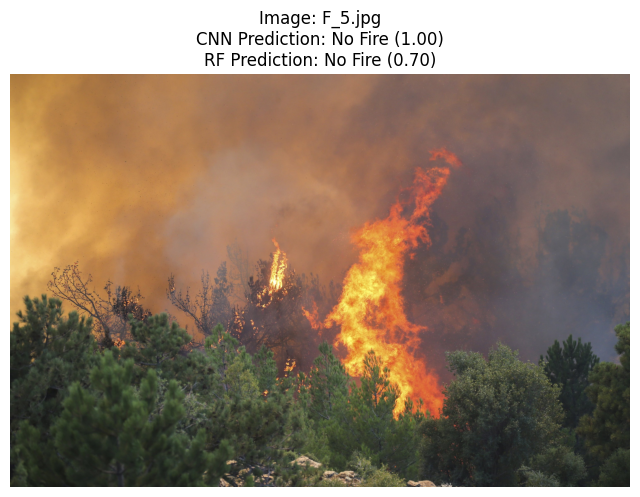


Prediction Results:
Image: /root/.cache/kagglehub/datasets/mohnishsaiprasad/forest-fire-images/versions/1/Data/Test_Data/Fire/F_5.jpg
CNN Prediction: No Fire (confidence: 1.00)
RF Prediction: No Fire (confidence: 0.70)


In [ ]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt

def get_random_test_image(test_data_path):
    """Get a random image path from Test_Data folder"""
    # Get all image files recursively
    image_paths = []
    for root, _, files in os.walk(test_data_path):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(root, file))

    if not image_paths:
        raise FileNotFoundError(f"No images found in {test_data_path}")

    return random.choice(image_paths)

def predict_and_display(image_path):
    """Predict and display results for a single image"""
    # Load and preprocess image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not read image from {image_path}")

    display_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_processed = cv2.resize(img, (128, 128)).astype('float32') / 255.0

    # CNN Prediction
    cnn_pred = model.predict(np.expand_dims(img_processed, axis=0), verbose=0)[0]
    cnn_class = np.argmax(cnn_pred)
    cnn_conf = cnn_pred[cnn_class]
    cnn_label = 'Fire' if cnn_class == 1 else 'No Fire'

    # RF Prediction
    rf_features = extract_features([img_processed])
    rf_features = scaler.transform(rf_features)  # Use the same scaler from training
    rf_class = rf_clf.predict(rf_features)[0]
    rf_conf = np.max(rf_clf.predict_proba(rf_features))
    rf_label = 'Fire' if rf_class == 1 else 'No Fire'

    # Display results
    plt.figure(figsize=(8, 6))
    plt.imshow(display_img)
    plt.title(f"Image: {os.path.basename(image_path)}\n"
              f"CNN Prediction: {cnn_label} ({cnn_conf:.2f})\n"
              f"RF Prediction: {rf_label} ({rf_conf:.2f})")
    plt.axis('off')
    plt.show()

    return {
        'image_path': image_path,
        'cnn_prediction': cnn_label,
        'cnn_confidence': float(cnn_conf),
        'rf_prediction': rf_label,
        'rf_confidence': float(rf_conf)
    }

# Path to your Test_Data folder
test_data_path = '/root/.cache/kagglehub/datasets/mohnishsaiprasad/forest-fire-images/versions/1/Data/Test_Data'

try:
    # Get and predict random image
    random_image = get_random_test_image(test_data_path)
    results = predict_and_display(random_image)

    print("\nPrediction Results:")
    print(f"Image: {results['image_path']}")
    print(f"CNN Prediction: {results['cnn_prediction']} (confidence: {results['cnn_confidence']:.2f})")
    print(f"RF Prediction: {results['rf_prediction']} (confidence: {results['rf_confidence']:.2f})")

except Exception as e:
    print(f"Error: {str(e)}")
    print("\nTroubleshooting steps:")
    print("1. Verify Test_Data path exists and contains images")
    print(f"   Current path: {test_data_path}")
    print("2. Check image file permissions")
    print("3. Ensure models are prop|erly trained")